# *Learning Semantic Maps with Topological Spatial Relations*

### Importing Modules

In [72]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import scipy.sparse as sp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
import igraph as ig
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn import Parameter
import torch.optim as optim
import math
import time
sns.set_theme(style="whitegrid", palette="pastel")

### Loading Dataset

In [73]:
data_list = []
flist = []
def import_node_db():
  global flist,data_list
  data_list = ["Stockholm","Saarbrucken","Freiburg"]
    
  floor_list1 = ["floor4_1","floor4_2","floor4_3","floor4_4","floor4_5","floor4_6","floor4_7","floor4_8",
                   "floor5_1","floor5_2","floor5_3","floor5_4","floor5_5","floor5_6","floor5_7","floor5_8",
                   "floor6_1","floor6_2","floor6_3","floor6_4","floor6_5","floor6_6","floor6_7","floor6_8","floor6_9",
                   "floor6_10","floor6_11","floor6_12","floor6_13","floor6_14","floor6_15","floor6_16","floor6_17","floor6_18",
                   "floor7_1","floor7_2","floor7_3","floor7_4","floor7_5","floor7_6","floor7_7","floor7_8"]

  floor_list2 = ["seq1_cloudy1","seq1_cloudy2","seq1_cloudy3","seq1_night1","seq1_night2","seq1_night3",
                 "seq2_cloudy1","seq2_cloudy2","seq2_cloudy3","seq2_night1","seq2_night2","seq2_night3",
                 "seq3_cloudy1","seq3_cloudy2","seq3_cloudy3","seq3_cloudy4","seq3_cloudy5","seq3_night1","seq3_night2","seq3_night3","seq3_sunny1","seq3_sunny2","seq3_sunny3",
                 "seq4_cloudy1","seq4_cloudy2","seq4_cloudy3","seq4_night1","seq4_night2","seq4_night3","seq4_sunny1","seq4_sunny2","seq4_sunny3"]

  floor_list3 = ["seq1_cloudy1","seq1_cloudy2","seq1_cloudy3","seq1_night1","seq1_night2","seq1_night3","seq1_sunny1","seq1_sunny2","seq1_sunny3","seq1_sunny4",
                 "seq2_cloudy1","seq2_cloudy2","seq2_cloudy3","seq2_night1","seq2_night2","seq2_night3","seq2_sunny1","seq2_sunny2","seq2_sunny3","seq2_sunny4",
                 "seq3_cloudy1","seq3_cloudy2","seq3_cloudy3","seq3_sunny1","seq3_sunny2","seq3_sunny3"]    

  flist = [floor_list1,floor_list2,floor_list3]
  # return flist
  node_df_list = []
  for i in range(3):
    df_list = []
    for j in flist[i]:
      if(i==0):
        p=6
      else:
        p=4
      node_df1 = pd.read_table("F:/prooo/dataset/{}/{}/nodes.dat".format(data_list[i],j),sep="\s+")
      # node_df1['floor']=j
      # node_df1['loc']=data_list[i]
      for k in range(8):
        node_df1["new_neighbor_ID_{}".format(k)] = [str(col) +"-"+ str(j) + "-" + str(data_list[i][:3])  for col in node_df1["neighbor_ID_{}".format(k)]]
      # node_df1['locfloor']=data_list[i]+"-"+j
      node_df1['node_id']=[str(col) +"-"+ str(j) + "-" + str(data_list[i][:3]) for col in node_df1['node_id']]
      node_df1['locfloor']=data_list[i]+"-"+j[:p]
      df_list.append(node_df1)
    node_df_list.append(pd.concat(df_list,ignore_index=True))
  main_list = pd.concat(node_df_list,ignore_index=True)
  return main_list
data = import_node_db()
data.head()

,node_id,placeholder,x,y,d1,d2,d3,d4,label,d5,...,view_num_7,new_neighbor_ID_0,new_neighbor_ID_1,new_neighbor_ID_2,new_neighbor_ID_3,new_neighbor_ID_4,new_neighbor_ID_5,new_neighbor_ID_6,new_neighbor_ID_7,locfloor
0,0-floor4_1-Sto,0,-1.000001,-0.200001,-1.025785,-0.097851,-1.000001,-0.200001,EV,1.205846e+09,...,0,1-floor4_1-Sto,2-floor4_1-Sto,-1-floor4_1-Sto,-1-floor4_1-Sto,-1-floor4_1-Sto,-1-floor4_1-Sto,-1-floor4_1-Sto,-1-floor4_1-Sto,Stockholm-floor4
1,1-floor4_1-Sto,0,-0.140001,0.259999,-0.303640,-0.002786,-0.200001,0.599999,EV,1.205846e+09,...,0,0-floor4_1-Sto,-1-floor4_1-Sto,-1-floor4_1-Sto,-1-floor4_1-Sto,-1-floor4_1-Sto,-1-floor4_1-Sto,-1-floor4_1-Sto,-1-floor4_1-Sto,Stockholm-floor4
2,2-floor4_1-Sto,0,-2.020001,-0.080001,-2.015833,-0.073241,-1.800001,-0.200001,DW,1.205846e+09,...,1,0-floor4_1-Sto,3-floor4_1-Sto,4-floor4_1-Sto,-1-floor4_1-Sto,-1-floor4_1-Sto,-1-floor4_1-Sto,-1-floor4_1-Sto,-1-floor4_1-Sto,Stockholm-floor4
3,3-floor4_1-Sto,0,-2.860001,0.499999,-3.019827,0.500790,-2.600001,0.599999,CR,1.205846e+09,...,0,2-floor4_1-Sto,4-floor4_1-Sto,6-floor4_1-Sto,9-floor4_1-Sto,-1-floor4_1-Sto,-1-floor4_1-Sto,-1-floor4_1-Sto,-1-floor4_1-Sto,Stockholm-floor4
4,4-floor4_1-Sto,0,-2.820001,-0.500001,-2.986465,-0.450972,-2.600001,-0.200001,CR,1.205846e+09,...,1,2-floor4_1-Sto,3-floor4_1-Sto,5-floor4_1-Sto,6-floor4_1-Sto,-1-floor4_1-Sto,-1-floor4_1-Sto,-1-floor4_1-Sto,-1-floor4_1-Sto,Stockholm-floor4


### Getting data for graph

In [74]:
graph_data = []
graph_data.append(pd.read_table("F:/prooo/dataset/Stockholm/floor4_1/nodes.dat",sep="\s+"))
graph_data.append(pd.read_table("F:/prooo/dataset/Saarbrucken/seq1_cloudy1/nodes.dat",sep="\s+"))
graph_data.append(pd.read_table("F:/prooo/dataset/Freiburg/seq1_cloudy1/nodes.dat",sep="\s+"))
graph_data[0].shape

(122, 34)

### Getting edges for graph

In [75]:
def get_graph_edge(gdata):
    temp_lst = []
    for i,data in gdata.iterrows():
          edges = []
          if(data.neighbor_ID_0!=-1):
                if (data.neighbor_ID_0,data.node_id) not in temp_lst:
                    edges.append((data.node_id,data.neighbor_ID_0))
          if(data.neighbor_ID_1!=-1):
                if (data.neighbor_ID_0,data.node_id) not in temp_lst:
                    edges.append((data.node_id,data.neighbor_ID_1))
          if(data.neighbor_ID_2!=-1):
                if (data.neighbor_ID_2,data.node_id) not in temp_lst:
                    edges.append((data.node_id,data.neighbor_ID_2))
          if(data.neighbor_ID_3!=-1):
                if (data.neighbor_ID_3,data.node_id) not in temp_lst:
                    edges.append((data.node_id,data.neighbor_ID_3))
          if(data.neighbor_ID_4!=-1):
                if (data.neighbor_ID_4,data.node_id) not in temp_lst:
                    edges.append((data.node_id,data.neighbor_ID_4))
          if(data.neighbor_ID_5!=-1):
                if (data.neighbor_ID_5,data.node_id) not in temp_lst:
                    edges.append((data.node_id,data.neighbor_ID_5))
          if(data.neighbor_ID_6!=-1):
                if (data.neighbor_ID_6,data.node_id) not in temp_lst:
                    edges.append((data.node_id,data.neighbor_ID_6))
          if(data.neighbor_ID_7!=-1):
                if (data.neighbor_ID_7,data.node_id) not in temp_lst:
                    edges.append((data.node_id,data.neighbor_ID_7))
          temp_lst.extend(edges)
    return temp_lst

In [76]:
edges_data = []
for graph in graph_data:
    temp_lst = []
    edges_data.append(get_graph_edge(graph))

In [77]:
n_vertices = []
for i in graph_data:
    n_vertices.append(i.shape[0])
n_vertices

[122, 75, 88]

In [78]:
g1 = ig.Graph(n_vertices[0], edges_data[0])
g2 = ig.Graph(n_vertices[1], edges_data[1])
g3 = ig.Graph(n_vertices[2], edges_data[1])

In [79]:
g1.vs["name"] = graph_data[0].label
g2.vs["name"] = graph_data[1].label
g3.vs["name"] = graph_data[2].label

<AxesSubplot:>

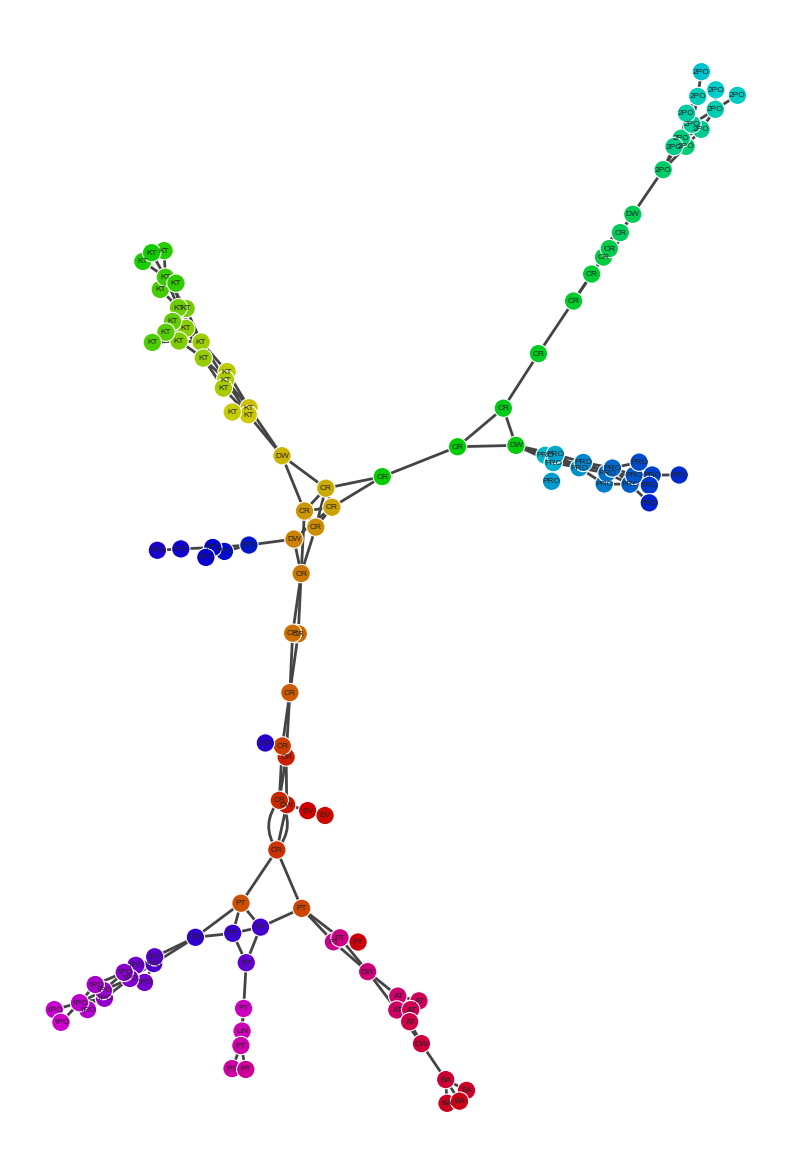

In [80]:
from igraph import RainbowPalette
fig, axis = plt.subplots(figsize=(15,15))
ig.plot(
    g1,
    target=axis,
    vertex_size=1.5,
    vertex_frame_width=0.8,
    vertex_color = RainbowPalette(n=n_vertices[0], s=1, v=0.8, alpha=1.00),
    vertex_frame_color="white",
    vertex_label=g1.vs["name"],
    vertex_label_size=6.0,
)

### Settling down "node_id"

In [81]:
node_number = 1
for i in data["node_id"]:
  # print(i)
  data = data.replace(i,node_number)
  node_number = node_number + 1

### Fixing "neighbor_id" according node_id

In [82]:
for i in data_list:
  for j in flist:
    for k in j:
      data.replace(str(-1)+"-"+k+"-"+i[:3],0,inplace=True)

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12009 entries, 0 to 12008
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   node_id            12009 non-null  int64  
 1   placeholder        12009 non-null  int64  
 2   x                  12009 non-null  float64
 3   y                  12009 non-null  float64
 4   d1                 12009 non-null  float64
 5   d2                 12009 non-null  float64
 6   d3                 12009 non-null  float64
 7   d4                 12009 non-null  float64
 8   label              12009 non-null  object 
 9   d5                 12009 non-null  float64
 10  neighbor_ID_0      12009 non-null  int64  
 11  affordance_0       12009 non-null  float64
 12  view_num_0         12009 non-null  int64  
 13  neighbor_ID_1      12009 non-null  int64  
 14  affordance_1       12009 non-null  float64
 15  view_num_1         12009 non-null  int64  
 16  neighbor_ID_2      120

### Dropping out unnecessary columns

In [84]:
df = data.drop(['d1','d2','d3','d4','d5','neighbor_ID_0','neighbor_ID_1','neighbor_ID_2','neighbor_ID_3','neighbor_ID_4','neighbor_ID_5','neighbor_ID_6','neighbor_ID_7'], axis=1)

### Encoding of object(string) column

In [85]:
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
df['locfloor']= label_encoder.fit_transform(df['locfloor'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12009 entries, 0 to 12008
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   node_id            12009 non-null  int64  
 1   placeholder        12009 non-null  int64  
 2   x                  12009 non-null  float64
 3   y                  12009 non-null  float64
 4   label              12009 non-null  object 
 5   affordance_0       12009 non-null  float64
 6   view_num_0         12009 non-null  int64  
 7   affordance_1       12009 non-null  float64
 8   view_num_1         12009 non-null  int64  
 9   affordance_2       12009 non-null  float64
 10  view_num_2         12009 non-null  int64  
 11  affordance_3       12009 non-null  float64
 12  view_num_3         12009 non-null  int64  
 13  affordance_4       12009 non-null  float64
 14  view_num_4         12009 non-null  int64  
 15  affordance_5       12009 non-null  float64
 16  view_num_5         120

### one hot encoding of target

In [86]:
def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)), dtype=np.int32)
    return labels_onehot

In [87]:
labels = encode_onehot(np.array(df['label']))
labels.shape

(12009, 22)

### Getting edges

In [88]:
def get_edge(data):
  edges = []
  if(data.new_neighbor_ID_0!=0):
    edges.append([data.node_id,data.new_neighbor_ID_0,data.locfloor])
  else:
    pass
  if(data.new_neighbor_ID_1!=0):
    edges.append([data.node_id,data.new_neighbor_ID_1,data.locfloor])
  else:
    pass
  if(data.new_neighbor_ID_2!=0):
    edges.append([data.node_id,data.new_neighbor_ID_2,data.locfloor])
  else:
    pass
  if(data.new_neighbor_ID_3!=0):
    edges.append([data.node_id,data.new_neighbor_ID_3,data.locfloor])
  else:
    pass
  if(data.new_neighbor_ID_4!=0):
    edges.append([data.node_id,data.new_neighbor_ID_4,data.locfloor])
  else:
    pass
  if(data.new_neighbor_ID_5!=0):
    edges.append([data.node_id,data.new_neighbor_ID_5,data.locfloor])
  else:
    pass
  if(data.new_neighbor_ID_6!=0):
    edges.append([data.node_id,data.new_neighbor_ID_6,data.locfloor])
  else:
    pass
  if(data.new_neighbor_ID_7!=0):
    edges.append([data.node_id,data.new_neighbor_ID_7,data.locfloor])
  else:
    pass
  return edges

In [89]:
graph_edges = []
for i,raw_data in df.iterrows():
  graph_edges.extend(get_edge(raw_data))
edges_unordered = np.array(graph_edges)
edges_unordered.shape

(42769, 3)

### Getting Degree Function

In [90]:
def get_degree(data):
    lst1 = []
    lst2 = []
    in_degree = []
    out_degree = []
    for i in range(data.shape[0]):
        lst1.append(data[i][1])
        lst2.append(data[i][0])
    for i in range(1,1000):
        in_degree.append(lst1.count(i))
        out_degree.append(lst2.count(i))
    return in_degree,out_degree

In [91]:
Y_indeg, Y_outdeg = get_degree(edges_unordered)

### Plotting

([<matplotlib.axis.XTick at 0x18d1398d6d8>,
 [Text(0, 0, ''), Text(0, 0, '')])

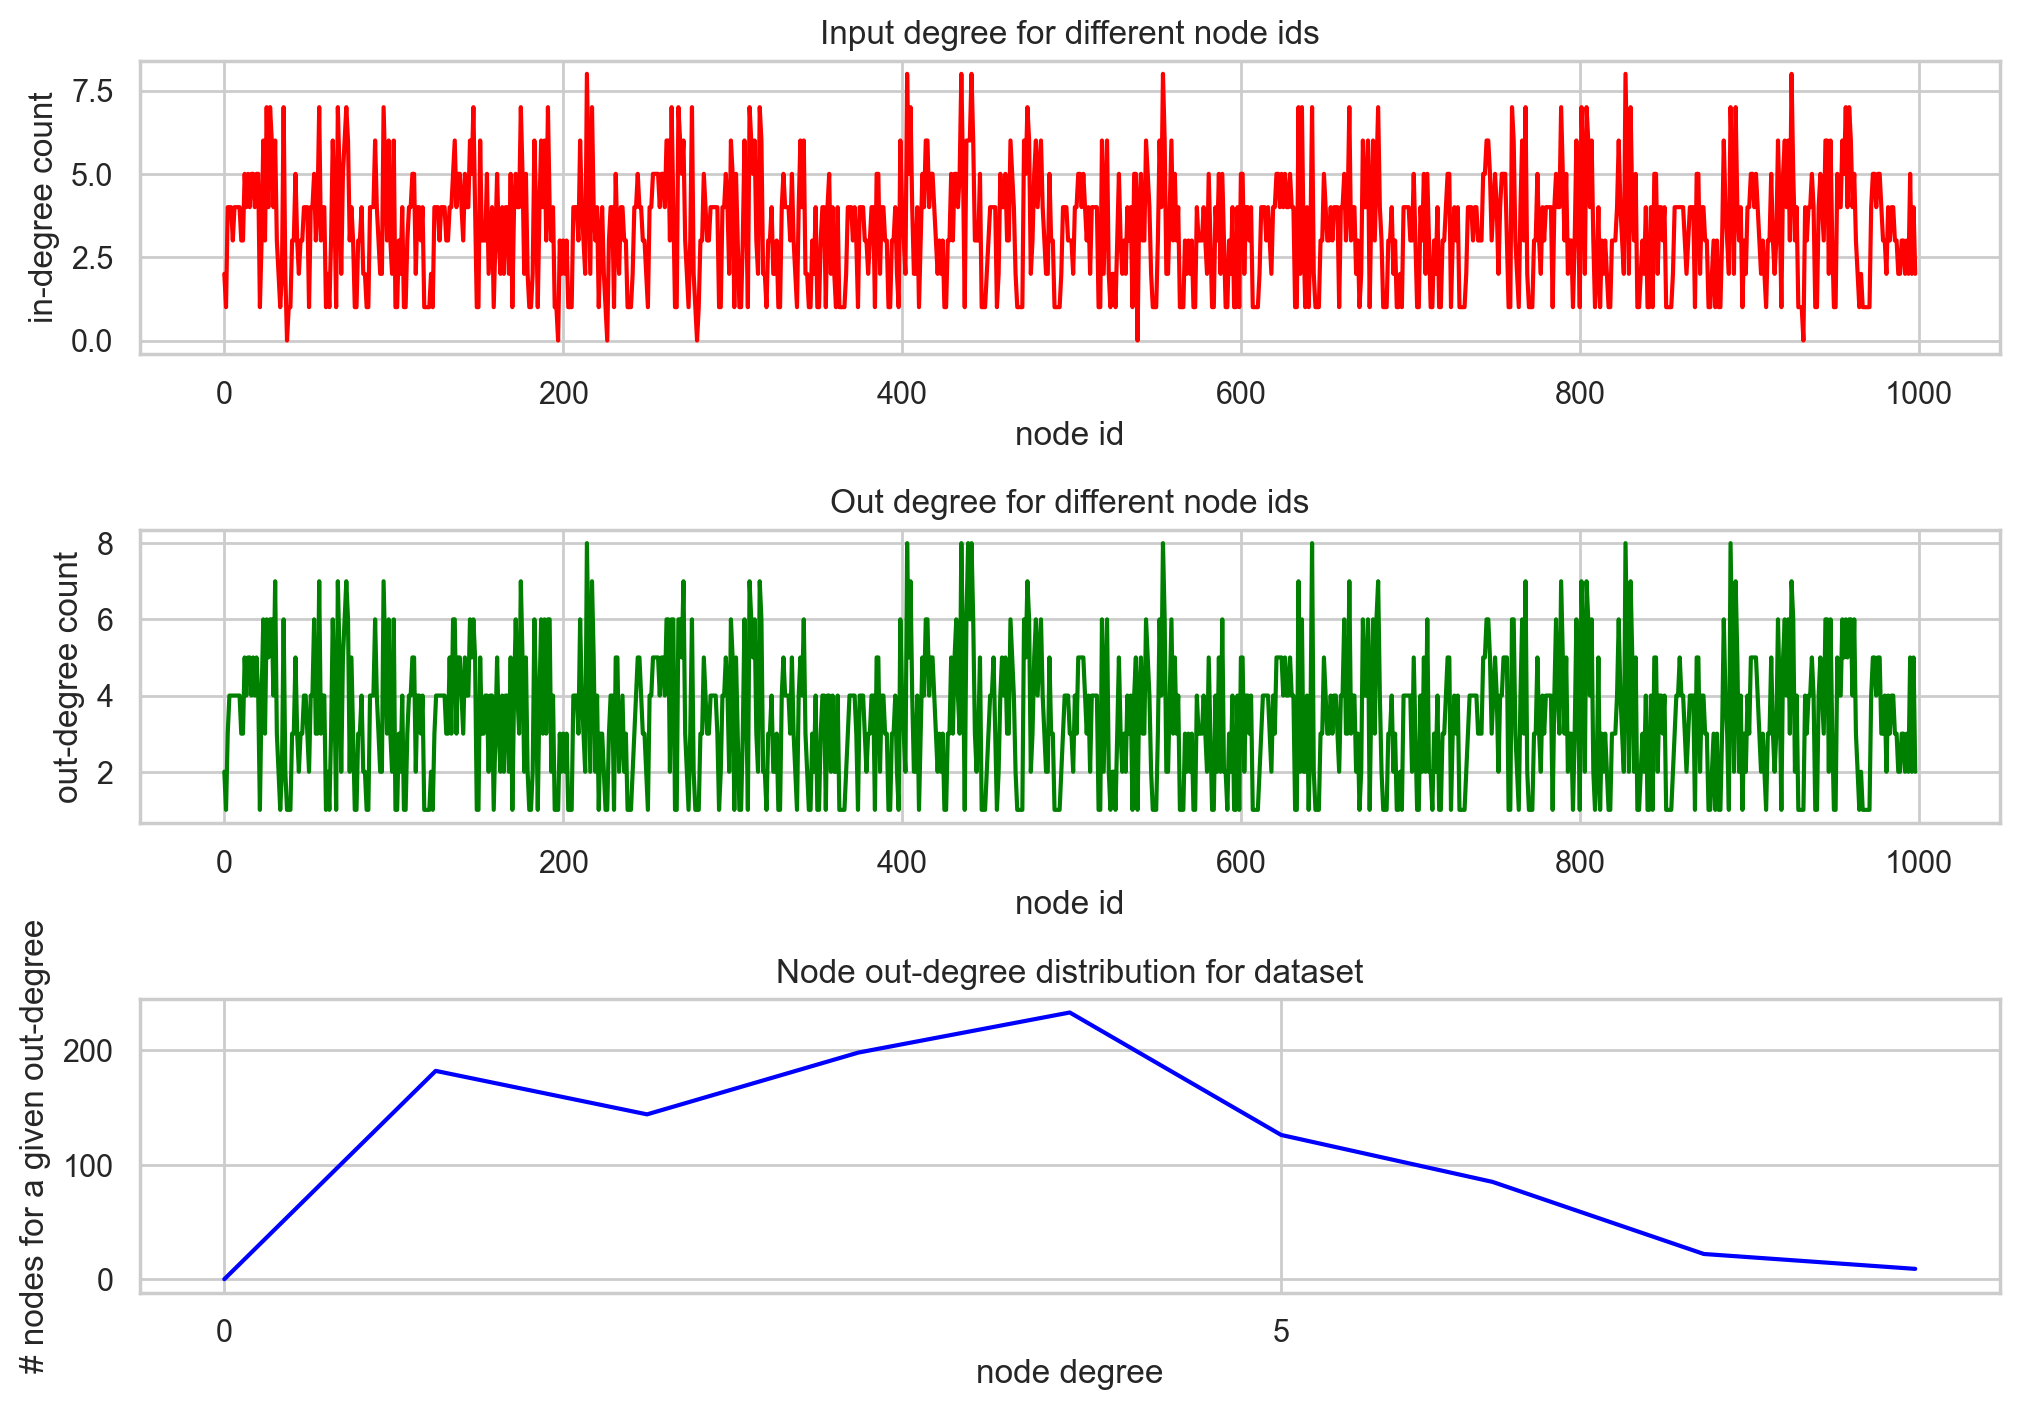

In [92]:
fig = plt.figure(figsize=(12,8), dpi=200)  # otherwise plots are really small in Jupyter Notebook
fig.subplots_adjust(hspace=0.6)
plt.subplot(311)
plt.plot(Y_indeg, color='red')
plt.xlabel('node id'); plt.ylabel('in-degree count'); plt.title('Input degree for different node ids')

plt.subplot(312)
plt.plot(Y_outdeg, color='green')
plt.xlabel('node id'); plt.ylabel('out-degree count'); plt.title('Out degree for different node ids')

hist = np.zeros(np.max(Y_outdeg) + 1)
for out_degree in Y_outdeg:
    hist[out_degree] += 1
    
plt.subplot(313)
plt.plot(hist, color='blue')
plt.xlabel('node degree')
plt.ylabel('# nodes for a given out-degree') 
plt.title(f'Node out-degree distribution for dataset')
plt.xticks(np.arange(0, len(hist), 5.0))

In [93]:
idx = np.array(df.index, dtype=np.int32)
idx_map = {j: i for i, j in enumerate(idx)}
idx.shape

(12009,)

In [94]:
df = df.drop(['node_id','label'], axis=1)

In [95]:
from sklearn.preprocessing import normalize
edges_unordered = normalize(edges_unordered)

In [96]:
features = sp.csr_matrix(df, dtype=np.float32)
edges = np.array(edges_unordered)
print(edges.shape)
adj = sp.coo_matrix(
        (np.ones(edges.shape[0]), 
        (edges[:, 0], edges[:, 1])),
        shape=(labels.shape[0], labels.shape[0]),
        dtype=np.float32
)

(42769, 3)


### Normalization of Features & adj matrix

In [97]:
def normalize(mx):
    """
    Row-normalize sparse matrix
    """
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

In [98]:
features = normalize(features)
adj = normalize(adj + sp.eye(adj.shape[0]))

In [99]:
idx_train = range(9000)
idx_val = range(9000, 11000)
idx_test = range(11000, 12000)

In [100]:
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """
    Convert a scipy sparse matrix to a torch sparse tensor.
    """
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

### Making Tensors

In [101]:
features = torch.FloatTensor(np.array(features.todense()))
labels = torch.LongTensor(np.where(labels)[1])
adj = sparse_mx_to_torch_sparse_tensor(adj)

In [102]:
idx_train = torch.LongTensor(idx_train)
idx_val = torch.LongTensor(idx_val)
idx_test = torch.LongTensor(idx_test)

### Checking for cuda availability

In [103]:
torch.cuda.is_available()

True

In [104]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

### GNN model

In [105]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn import Parameter
import math


class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))

        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))        
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return f'{self.__class__.__name__} ({self.in_features} -> {self.out_features})'


class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)

### Model Instance

In [106]:
model = GCN(
        nfeat=features.shape[1],
        nhid=16,
        nclass=labels.max().item() + 1,
        dropout=0.5
    )

In [107]:
optimizer = optim.SGD(
        model.parameters(),
        lr=0.01, 
        weight_decay=5e-4
    )

In [108]:
model.cuda()
features = features.cuda()
adj = adj.cuda()
labels = labels.cuda()
idx_train = idx_train.cuda()
idx_val = idx_val.cuda()
idx_test = idx_test.cuda()

### Train, Accuracy & Test Functions

In [109]:
def train(model,adj, epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    # if not args.fastmode:
    #     # Evaluate validation set performance separately,
    #     # deactivates dropout during validation run.
    #     model.eval()
    #     output = model(features, adj)

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))

In [110]:
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

In [111]:
def test(model):
    model.eval()
    output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:", "loss= {:.4f}".format(loss_test.item()), "accuracy= {:.4f}".format(acc_test.item()))

### Training

In [112]:
t_total = time.time()
for epoch in range(500):
  train(model, adj, epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

Epoch: 0001 loss_train: 3.0970 acc_train: 0.0163 loss_val: 3.0808 acc_val: 0.0190 time: 4.1111s
Epoch: 0002 loss_train: 3.0963 acc_train: 0.0161 loss_val: 3.0794 acc_val: 0.0155 time: 0.0156s
Epoch: 0003 loss_train: 3.0936 acc_train: 0.0179 loss_val: 3.0793 acc_val: 0.0200 time: 0.0000s
Epoch: 0004 loss_train: 3.0936 acc_train: 0.0149 loss_val: 3.0787 acc_val: 0.0155 time: 0.0000s
Epoch: 0005 loss_train: 3.0939 acc_train: 0.0179 loss_val: 3.0755 acc_val: 0.0145 time: 0.0156s
Epoch: 0006 loss_train: 3.0926 acc_train: 0.0168 loss_val: 3.0748 acc_val: 0.0190 time: 0.0000s
Epoch: 0007 loss_train: 3.0913 acc_train: 0.0173 loss_val: 3.0751 acc_val: 0.0130 time: 0.0000s
Epoch: 0008 loss_train: 3.0913 acc_train: 0.0164 loss_val: 3.0720 acc_val: 0.0140 time: 0.0156s
Epoch: 0009 loss_train: 3.0895 acc_train: 0.0190 loss_val: 3.0701 acc_val: 0.0200 time: 0.0000s
Epoch: 0010 loss_train: 3.0886 acc_train: 0.0169 loss_val: 3.0688 acc_val: 0.0205 time: 0.0156s
Epoch: 0011 loss_train: 3.0871 acc_train

### Testing

In [113]:
test(model)

Test set results: loss= 2.6505 accuracy= 0.3610
